In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
train_file_name = 'dota2Train.csv'
test_file_name = 'dota2Test.csv'

train_data = pd.read_csv(train_file_name, header=None)
test_data = pd.read_csv(test_file_name, header=None)

test_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
0,-1,223,8,2,0,-1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
1,1,227,8,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
2,-1,136,2,2,1,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,227,2,2,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,184,2,3,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,231,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,-1,0,0,0
6,1,152,2,2,0,0,0,0,0,-1,...,0,1,0,0,0,0,0,0,0,0
7,-1,153,2,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,-1,223,8,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,-1,153,2,2,0,0,0,0,-1,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# 0. Team won the game (1 or -1)
# 1. Cluster ID (related to location)
# 2. Game mode (eg All Pick)
# 3. Game type (eg. Ranked)

def rename_columns(dataset):
    dataset.rename(columns={0:'result', 1:'cluster_id', 2:'game_mode', 3:'game_type'}, inplace=True)

In [4]:
rename_columns(train_data)
rename_columns(test_data)
test_data.head()
# train_data[0] = train_data[0].map({-1:0, 1:1})
# test_data[0] = test_data[0].map({-1:0, 1:1})
train_data['result'] = train_data['result'].map({-1:0, 1:1})
test_data['result'] = test_data['result'].map({-1:0, 1:1})
# train_data.drop(columns=1, inplace=True)
# test_data.drop(columns=1, inplace=True)
train_data.drop(columns='cluster_id', inplace=True)
test_data.drop(columns='cluster_id', inplace=True)

test_data.head()

,result,game_mode,game_type,4,5,6,7,8,9,10,...,107,108,109,110,111,112,113,114,115,116
0,0,8,2,0,-1,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
1,1,8,2,0,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
2,0,2,2,1,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2,2,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2,3,0,0,0,-1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Win ratios of every hero
# How to calculate:
# Count how many times a hero was picked, and compare to total number of games (division).
# The 'result' column doesn't matter since the calculation of hero win percentage does not concern
# who won the game, and any hero can only be picked by 1 side every game.

t_test_data = test_data.drop(columns=['result', 'game_mode', 'game_type'])
t_test_data = t_test_data.apply(pd.value_counts)
t_test_data = t_test_data.fillna(0)
t_test_data = t_test_data.T
t_test_data['Pick percentage'] = (t_test_data[-1]+t_test_data[1])/(t_test_data[-1]+t_test_data[1]+t_test_data[0])*100
t_test_data.head(10)

,-1,0,1,Pick percentage
4,824.0,8662.0,808.0,15.853895
5,1101.0,8062.0,1131.0,21.682534
6,154.0,9988.0,152.0,2.972605
7,621.0,9052.0,621.0,12.065281
8,601.0,9153.0,540.0,11.084127
9,1181.0,7925.0,1188.0,23.013406
10,640.0,8986.0,668.0,12.706431
11,1329.0,7687.0,1278.0,25.325432
12,1734.0,6760.0,1800.0,34.330678
13,558.0,9212.0,524.0,10.510977


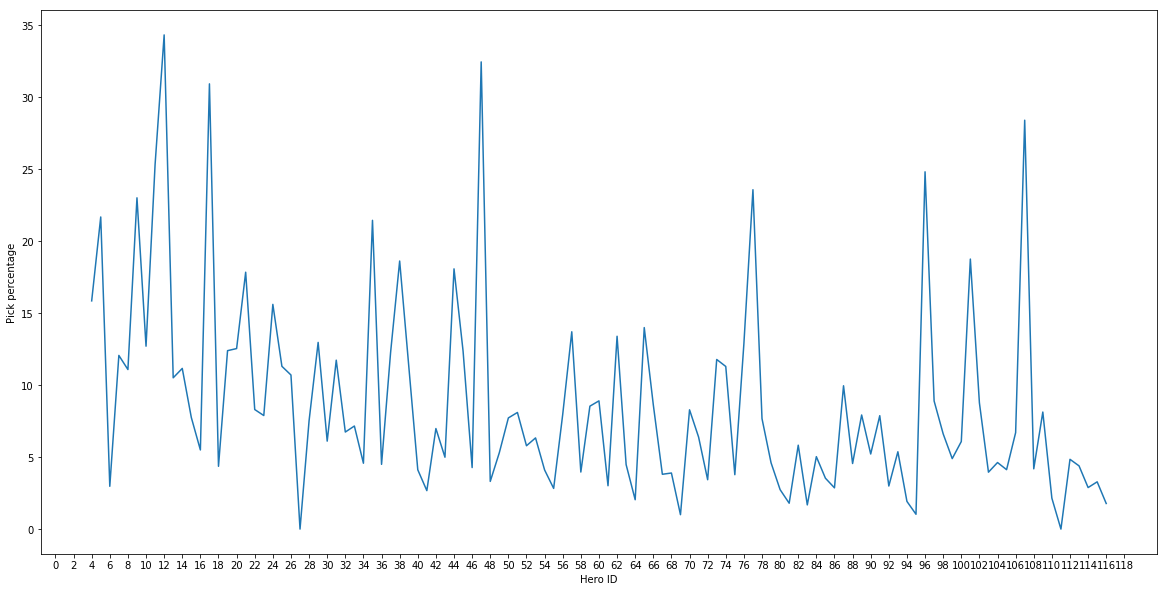

In [6]:
hero_win_rates = t_test_data['Pick percentage']
plt.figure(figsize=(20,10))
plt.xticks(np.arange(0, 120, step=2))
plt.xlabel("Hero ID")
plt.ylabel("Pick percentage")
plt.plot(hero_win_rates)

In [7]:
team_win_data = train_data.groupby('result').count()
team_win_data = team_win_data.game_mode
total_games = team_win_data.iloc[0]+team_win_data.iloc[1]
team_win_data['team 0 win rate'] = team_win_data.iloc[0]/total_games
team_win_data['team 1 win rate'] = team_win_data.iloc[1]/total_games
team_win_data

result
0                  43868.000000
1                  48782.000000
team 0 win rate        0.473481
team 1 win rate        0.526519
Name: game_mode, dtype: float64

In [8]:
test_team_win_data = test_data.groupby('result').count()
test_team_win_data = test_team_win_data.game_mode
total_games = test_team_win_data.iloc[0]+test_team_win_data.iloc[1]
test_team_win_data['team 0 win rate'] = test_team_win_data.iloc[0]/total_games
test_team_win_data['team 1 win rate'] = test_team_win_data.iloc[1]/total_games
test_team_win_data

result
0                  4792.000000
1                  5502.000000
team 0 win rate       0.465514
team 1 win rate       0.534486
Name: game_mode, dtype: float64

In [9]:
# train_data['side win rate'] = ""
# test_data['side win rate'] = ""

# train_data.loc[train_data.result == 1, ['side win rate']] = team_win_data['team 1 win rate']
# train_data.loc[train_data.result == 0, ['side win rate']] = team_win_data['team 0 win rate']
# test_data.loc[test_data.result == 1, ['side win rate']] = test_team_win_data['team 1 win rate']
# test_data.loc[test_data.result == 0, ['side win rate']] = test_team_win_data['team 0 win rate']
# train_data.head()

In [10]:
# Number of times "Dire" and "Radiant" won. Dire and Radiant are two opposing teams of the game.
train_data.result.value_counts()

1    48782
0    43868
Name: result, dtype: int64

In [11]:
def split(train_d, test_d):
    x_train = train_d.loc[:, train_d.columns != 'result']
    y_train = train_d['result']
    x_test = test_d.loc[:, test_d.columns != 'result']
    y_test = test_d['result']
    return x_train, y_train, x_test, y_test

In [12]:
def evaluate(model, x_train, y_train, x_test, y_test):
    train_preds = model.predict(x_train)
    test_preds = model.predict(x_test)
    print(test_preds)
    train_acc = metrics.accuracy_score(y_train, train_preds)
    test_acc = metrics.accuracy_score(y_test, test_preds)
    print('Train accuracy: %s' % train_acc)
    print('Test accuracy: %s' % test_acc)
    plt.plot(x_test)
    plt.plot(test_preds)

In [13]:
def split_train_evaluate(model, train_d, test_d):
    x_train, y_train, x_test, y_test = split(train_data, test_data)
    model.fit(x_train, y_train)
    evaluate(model, x_train, y_train, x_test, y_test)

[0 1 1 ... 1 1 1]
Train accuracy: 0.6010577441985969
Test accuracy: 0.5982125510005829
{'class_weight': 'None', 'solver': 'lbfgs'}


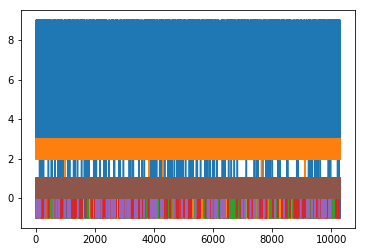

In [14]:
x_train, y_train, x_test, y_test = split(train_data, test_data)
lr = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='ovr', C=0.7)
parameters = {'class_weight': ['None', 'balanced'],
'solver':['lbfgs', 'sag', 'saga'],
}
clf = GridSearchCV(lr, parameters, cv=5)#LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='ovr')
clf.fit(x_train, y_train)
split_train_evaluate(clf, train_data, test_data)
print(clf.best_params_)